In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#For Multiple Detections & False Positives
from scipy.ndimage.measurements import label
import time
from moviepy.editor import VideoFileClip
import datetime
# Using widgets
import ipywidgets as widgets
import features
import collections

## 1.Changing to an appropriate color space

It helps us more to find the features in an image

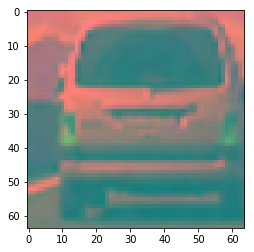

In [16]:
image = cv2.imread('./all/1200.png')
image = features.convert_color(image, 'YUV')
plt.imshow(image)
plt.show()

## 2.Resize image

While it could be cumbersome to include three color channels of a full resolution image, you can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As you can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.

A convenient function for scaling down the resolution of an image is OpenCV's **cv2.resize()**.

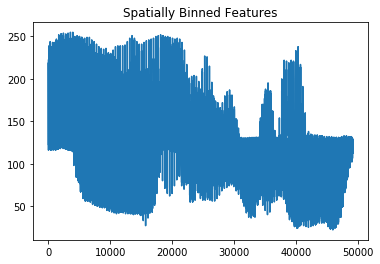

In [17]:
image = cv2.imread('./all/1200.png')
feature_vec = features.bin_spatialI(features.convert_color(image, 'YCrCb'), size=(128, 128))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

## 3.Generate the color histogram

With **np.histogram()**, you don't actually have to specify the number of bins or the range, but here I've arbitrarily chosen 32 bins and specified **range=(0, 256)** in order to get orderly bin sizes. **np.histogram()** returns a tuple of two arrays. 

In this case, for example, **rhist[0]** contains the counts in each of the bins and **rhist[1]** contains the bin edges (so it is one element longer than **rhist[0]**).

These, collectively, are now our feature vector for this particular cutout image. We can concatenate them in the following way:

**hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))**

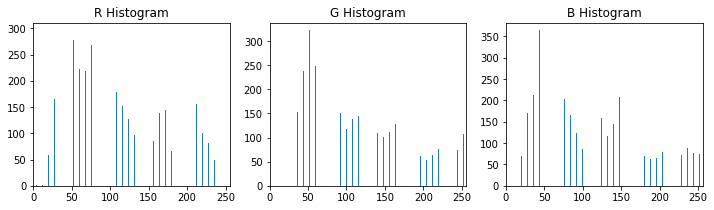

In [18]:
'''
This part is only for testing the above function
'''
image = cv2.imread('./all/1200.png')
channel1, channel2, channel3 , hist_features = features.color_hist(image)

# Generating bin centers
bin_edges = channel1[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, channel1[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, channel2[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, channel3[0])
plt.xlim(0, 256)
plt.title('B Histogram')
plt.show()

## 4.Extracting the Histogram of Oriented Gradient (scikit-image HOG)


The scikit-image **hog()** function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include **orientations**, **pixels_per_cell** and **cells_per_block**.

The number of **orientations** is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The **pixels_per_cell** parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The **cells_per_block** parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional power law or "gamma" normalization scheme set by the flag **transform_sqrt**. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

The **visualise=True** flag tells the function to output a visualization of the HOG feature computation as well, which we're calling **hog_image** in this case.

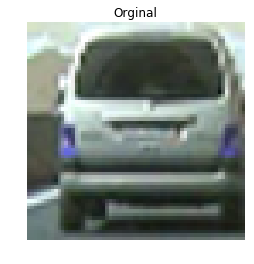

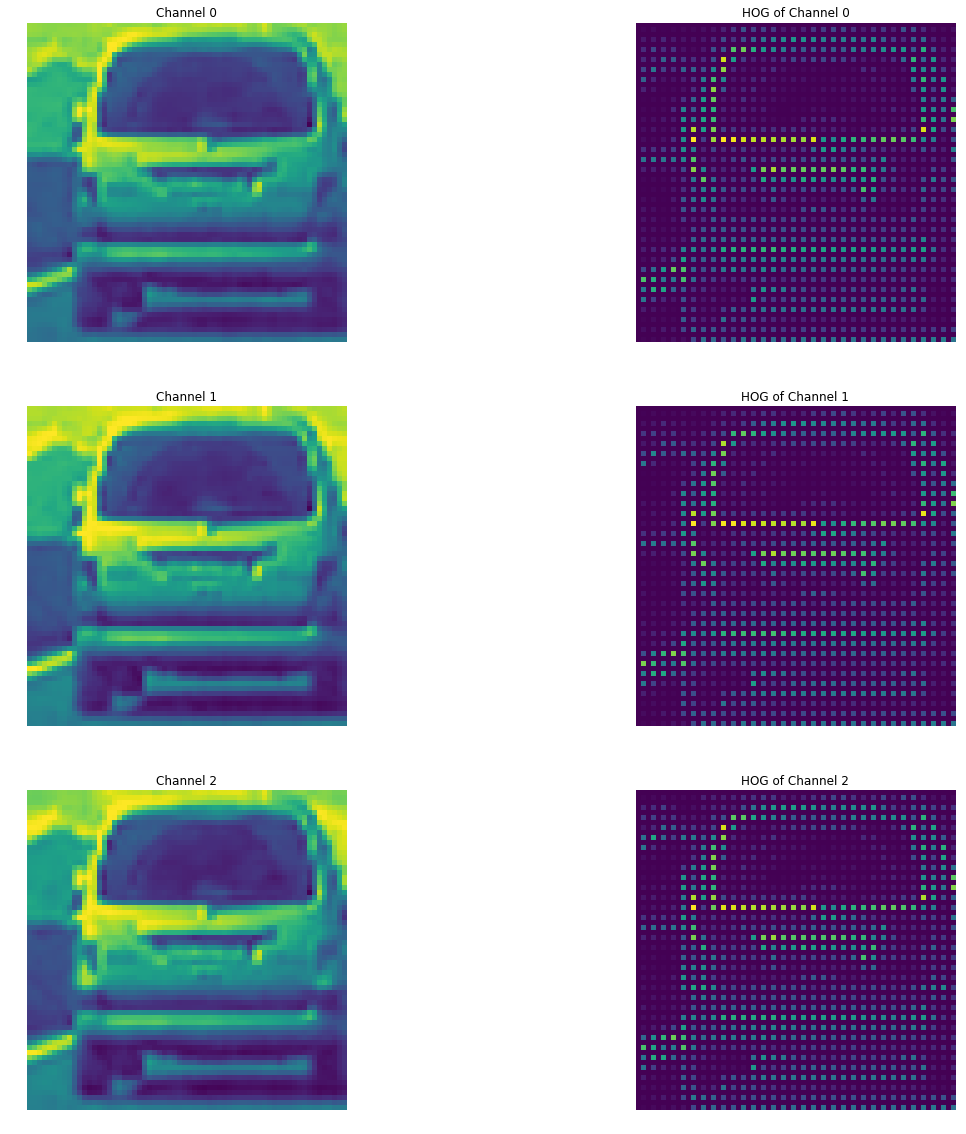

In [19]:
image = cv2.imread('./all/1200.png')
plt.imshow(image )
plt.title('Orginal')
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 20))
subplotcounter = 1
for channel in range(image.shape[2]):
    
    plt.subplot(3, 2, subplotcounter)
    plt.imshow(image[:,:,channel] )
    plt.title('Channel {}'.format(channel))
    plt.axis('off')
    subplotcounter = subplotcounter + 1

    plt.subplot(3, 2,subplotcounter )
    f,g = features.get_hog_features(image[:,:,channel], 9, 8,2,vis=True, feature_vec=True)
    plt.imshow(g )
    plt.title('HOG of Channel {}'.format(channel))
    plt.axis('off')
    subplotcounter = subplotcounter + 1

plt.show() 

## 5. Extracting features function

In [ ]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    
    showshape=1

    # Create a list to append feature vectors to
    myfeatures = []
    
    # Iterate through the list of images
    for file in imgs:

        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        feature_image = features.convert_color(image, color_space=cspace)        
        
        allfeatures=[]

        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = features.bin_spatialI(feature_image, size=spatial_size)
            allfeatures.append(spatial_features)
            if showshape == 1:
                print('Shape {} with shape {}'.format('Spatioal',spatial_features.shape ))
           

        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            a,b,c,hist_features = features.color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            allfeatures.append(hist_features)
            if showshape == 1:
                print('Shape {} with shape {}'.format('His',hist_features.shape ))
        
        
        
        # Compute individual channel HOG features for the entire image
        hog_features = []
        if hog_feat == True :
            if hog_channel == 'ALL':
                for channel in range(feature_image.shape[2]):
                    hog_features.append( features.get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                          cell_per_block, feature_vec=False))
                hog_features = np.ravel(hog_features)   
            else:
                hog_features = features.get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                        cell_per_block, feature_vec=False)
            allfeatures.append(hog_features)  
            if showshape == 1:
                print('Shape {} with shape {}'.format('Hog',hog_features.shape ))
            
        
        
        # Append the new feature vector to the features list
        myfeatures.append(np.concatenate(allfeatures))

        showshape = 0
        
            
    # Return list of feature vectors
    return myfeatures


## 6.Global values

In [ ]:
'''
The input for training model and predicting should have same size.
'''
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" 
spatial_size = (16, 16) 
hist_bins = 128   
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
hist_range = (0, 256)

## 7.Load Dataset

In [ ]:
'''
This part is only for testing the above function
'''
images = glob.iglob('./all/vehicles/**/*.png',recursive=True)
cars = []
notcars = []
for image in images:
    cars.append(image)
images = glob.glob('./all/non-vehicles/**/*.png',recursive=True)
for image in images:
    notcars.append(image)    
print('Count of vehicles {} , Count of non-vehicles {}'.format(len(cars) , len(notcars)))


## 8.Extract Dataset's features

In [ ]:
'''
Extract HOG, Spatial and Histogram features
Prepare dataset
'''
car_features = extract_features(cars, cspace = color_space, 
                                spatial_size = spatial_size,
                                hist_bins = hist_bins, 
                                hist_range = hist_range)
notcar_features = extract_features(notcars, cspace = color_space, 
                                   spatial_size = spatial_size,
                                   hist_bins = hist_bins, 
                                   hist_range = hist_range)



## 9.Train Linear SVC(support vector classifier) Classifier

**Tuning the SVM Hyperparameters**

The gamma value and the C value that minimize prediction error. To tune the SVM vehicle detection model,I will tune C parametr.

In [ ]:

if len(car_features) > 0 and len(notcar_features) > 0:
    
    # Scale the feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)      
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)    
    
    '''
    Split up data into randomized training and test sets.
    This performs both the shuffle and split of the data and you'll 
    call it like this.
    '''
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    svc = LinearSVC(C=0.0005)
    
    svc.fit(X_train, y_train)

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    print('My SVC predicts: ', svc.predict(X_test[0:10]))

    print('For labels: ', y_test[0:10])    
else: 
    print('Function returns empty feature vectors because the car and non-car images are empty.')


## 10.Save model

In [ ]:
obj = {
        "svc": svc,
        "scaler": X_scaler,
        "orient" : orient,
        "pix_per_cell": pix_per_cell,
        "cell_per_block": cell_per_block,
        "spatial_size": spatial_size,
        "hist_bins": hist_bins,
        "color_space": color_space,
        "hog_channel": hog_channel,
        "spatial_feat": spatial_feat,
        "hist_feat": hist_feat,
        "hog_feat": hog_feat,
        "hist_range":hist_range
    }
pickle.dump(obj, open('svc_pickle.p', 'wb'))

## 11.Read model

In [2]:
import random
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
global  svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins,ystart,ystop
        
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
color_space = dist_pickle["color_space"]

spatial_size = dist_pickle["spatial_size"] # Spatial binning dimensions
spatial_feat = dist_pickle["spatial_feat"] # Spatial features on or off

#------------------------------------
# Color Histogran Classify
#------------------------------------
hist_bins = dist_pickle["hist_bins"]    # Number of histogram bins
hist_feat = dist_pickle["hist_feat"] # Histogram features on or off

#------------------------------------
# HOG Classify
#------------------------------------
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"] # Can be 0, 1, 2, or "ALL"
hog_feat = dist_pickle["hog_feat"] # HOG features on or off
hist_range = dist_pickle["hist_range"]

ystart = 400
ystop = 656
scales = [1,1.3,1.5,1.8,2,2.4,3]


## 12. Using LinearSVC Classifier to detect vehicles

In [3]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size,hist_bins):
    
    draw_img = np.copy(img)

    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = features.convert_color(img_tosearch, 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = features.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = features.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = features.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = features.bin_spatialI(subimg, spatial_size)
            _,_,_,hist_features = features.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left,  ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                cv2.imwrite('./subimg/'+str(datetime.datetime.now()).replace(':','_')+'.png',subimg)
                
    return window_list

## 13. Drawing boxes in an image

In [4]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## 14. Multiple Detections & False Positives
**Solution is Heat-Map**
<br>
To make a heat-map, we are simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier.
<br>
If the classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, you can reject areas affected by false positives therefore we use the *apply_threshold* function.

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

I integrate a heat map over images, such that areas of multiple detections get "hot", while transient false positives stay "cool". I can then simply threshold the heatmap to remove false positives with this line.
```ruby
heatmap[heatmap <= threshold] = 0
```
<br>
once heat-map is thresholded, there are many ways to figure out how many cars we have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the *label()* function from *scipy.ndimage.measurements*.

In [6]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## 15. Finding boxes as the position of vehicle
Output: is the boxes which will be the position of vehicles.

In [8]:
def process_bboxes(image,predicated_windows,threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    # Add heat to each box in box list
    heat = add_heat(heat,predicated_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)

    return bbox_list

## 16. Draw boxes with label

In [13]:
# Draw boxes with car label 
def draw_car_boxes(img, bbox_list):
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 1
    fontColor              = (0,0,255)
    lineType               = 2   
    car_number             = 1
    
    for bbox in bbox_list:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.putText(img,'Car{}'.format(car_number), 
                    bbox[0], 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
        car_number = car_number + 1
        
    # Return the image
    return img

## 17. Function for processing each frame

Here the idea is utilizing the fact that in the subsequent frames the cars are located at or near the same positions, while false positives are present only for 1-2 frames. There is no such optimization in the source code.

The simplest way to implement this is using multi-frame accumulated heatmap: just store the heatmap of the last N frames (N can be 5 or 8) and do the same thresholding and labelling on the sum (or average) of these heatmaps.

As a side effect this techniqe results much more stable bounding boxes as well.

To store the heatmaps I suggest using collections.deque, in this way you do not need to delete the oldest heatmap:

```python
from collections import deque
history = deque(maxlen = 8)
...
history.append(current_heat_map)
...
```

In [10]:
def process_image( image, n_frames=10 ):
    
    if process_image.global_cache is None:
        buffered_bboxes = collections.deque(maxlen=n_frames)
        actual_boxes = collections.deque(maxlen=n_frames)
        global_cache= {
            'buffered_bboxes': buffered_bboxes,
            'actual_boxes':actual_boxes
        }        
    else:
        global_cache = process_image.global_cache
        buffered_bboxes = global_cache['buffered_bboxes']
        actual_boxes = global_cache['actual_boxes']
        

    # predicting windows with different scales
    predicated_windows = None
    for scale in scales:
        
        
        if predicated_windows is None:
            
            # for first time this logic will be used.
            predicated_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        else:
            
            # for second time and next iterations this logic will be used
            predicated_windows = predicated_windows + find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            
    # Identify boxes using threshold to avoid false positives
    bbox_list = process_bboxes(image,predicated_windows,threshold=0)
    
    # keep the last n_frames and in this case is 10
    buffered_bboxes.append(bbox_list)
    
    # save the buffered frames in global cache
    global_cache['buffered_bboxes'] = buffered_bboxes
    process_image.global_cache = global_cache
    
    # make a list of boxes to make average list
    avg_bbox_list=[]
    for box in buffered_bboxes:
        for b in box:
            avg_bbox_list.append(b)
            
    # Smoothing - Apply avg heatmap to further reduce false positives and smooth the bounding boxes
    bbox_list = process_bboxes(image,avg_bbox_list,threshold=5)         
    draw_img = draw_car_boxes(image, bbox_list)
        
    return draw_img

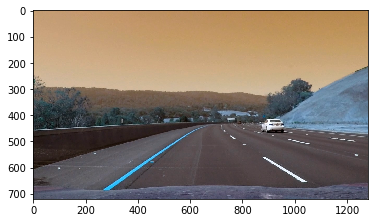

2.08 Seconds for processing an image.


In [14]:

t=time.time()
 process_image.global_cache = None
impath = './test_images/test3.jpg'
image = cv2.imread(impath)
draw_img = process_image (image)
   
plt.imshow(draw_img)
plt.show()

t2 = time.time()
print(round(t2-t, 2), 'Seconds for processing an image.')


In [15]:
 process_image.global_cache = None
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [39:17<00:01,  1.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 39min 18s
